# Optimal Portfolio

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Efficient Frontier

Пояснение выбора списка активов: 

+ Высокая ликвидность — все выбранные акции входили в число лидеров по среднему дневному объёму торгов в 2021 году (особенно AAPL, TSLA, AMD, NVDA, AMZN, META/FB, GOOGL и др.). Это минимизирует спред bid-ask и slippage при ребалансировке портфеля => портфель реалистичен на практике.
+ Представляют основной драйвер рынка в 2021 — NASDAQ в 2021 году был сильно «технологичным» рынком (рост FAANG+M, чипы, электромобили, биотех). Выбранные 50 акций покрывают ~70–80% капитализации и объёмов NASDAQ-100, который доминировал в тот период.
+ Хорошая диверсификация внутри технологического рынка:
    + Крупные платформы / потребительский сектор: AAPL, AMZN, META, GOOGL/GOOG, NFLX
    + Полупроводники / чипы: NVDA, AMD, INTC, QCOM, AVGO, ASML, MU, LRCX, KLAC
    + Биотехнологии / здравоохранение: AMGN, GILD, REGN, ILMN, DXCM
    + Потребительские / ритейл / сервисы: COST, PEP, MDLZ, ORLY, DLTR
    + Телеком / медиа: CMCSA, CHTR
    + Другие: PAYX, ADP, CTSH, CSX, BKR и т.д.

#### Data load & preprocessing

In [2]:
# Загрузка данных из CSV
# Что делает: Читает файл, удаляет столбец даты и преобразует всё в числа.
# Использует файл с ценами закрытия акций за 2021 год.
try:
    # Пытаемся загрузить обработанный, если нет - сырой
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
except FileNotFoundError:
    try:
        data = pd.read_csv("data/raw/NASDAQ_FULL_2021_Close.csv")
        if 'Date' in data.columns:
            data.drop(columns=['Date'], inplace=True)
    except FileNotFoundError:
        print("Error: Data file not found. Please upload the dataset.")
data.head()

,AAPL,ADBE,ADI,ADP,ADSK,AMD,AMGN,AMZN,ASML,AVGO,...,NFLX,NVDA,NXPI,ORLY,PAYX,PEP,PYPL,QCOM,REGN,TSLA
0,125.974472,485.339996,133.808731,152.303543,296.839996,92.300003,193.642517,159.331497,477.949219,38.253105,...,52.285999,13.076726,148.497253,30.264668,78.469963,123.652855,231.385101,133.337646,480.196747,243.256668
1,127.531975,485.690002,136.200485,151.879822,301.700012,92.769997,194.582214,160.925507,483.072784,38.512192,...,52.080002,13.367159,151.823929,30.085333,78.174713,124.021347,234.368210,136.866333,480.783478,245.036667
2,123.239044,466.309998,136.814453,151.348007,302.869995,90.330002,199.272507,156.919006,468.600555,38.274708,...,50.049000,12.579126,154.618973,31.011999,79.156013,122.504295,226.306839,135.752930,467.497162,251.993332
3,127.444351,477.739990,142.596786,152.204361,315.200012,95.160004,199.930344,158.108002,479.316162,39.887695,...,50.889000,13.306579,160.364944,31.326668,79.486008,122.110023,234.497894,139.802490,478.545929,272.013336
4,128.544403,485.100006,143.632263,154.187531,319.850006,94.580002,203.749207,159.134995,486.303711,40.090115,...,51.040001,13.239518,160.401611,31.861334,79.911537,123.575684,241.900803,140.646515,495.979248,293.339996


In [3]:
# Очистка данных: преобразование в числа и удаление пропусков (NaN)
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)

Log returns:

In [4]:
# Расчет дневных доходностей
# Вычисляет логарифмические доходности (дневные).

eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Отбросим первую строку, в которой пропуски из-за того, что у первого дня нет предыдущего
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


### Выбор активов и расчет статистики

In [5]:
# Выбор 50 акций и фильтрация
# Оставляет в выборке только 50 заданных тикеров.
# Обоснование выбора: высокая ликвидность (объемы торгов) и репрезентативность секторов (Tech, Bio, Chips).

tickers = [
    'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO',
    'BIDU', 'BKNG', 'BKR', 'CDNS', 'CHTR', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTSH',
    'DLTR', 'DXCM', 'EA', 'EBAY', 'EXC', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN',
    'INTC', 'ISRG', 'KDP', 'KLAC', 'LRCX', 'MAR', 'MDLZ', 'META', 'MNST', 'MU',
    'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PEP', 'PYPL', 'QCOM', 'REGN', 'TSLA'
]

In [6]:
# Фильтруем данные по выбранным тикерам
data = data[tickers]
log_returns = log_returns[tickers]

In [7]:
# Расчет средних доходностей и ковариации
# Находит вектор средних доходностей (mu) и матрицу ковариации (Sigma).
mu = log_returns.mean()
Sigma = log_returns.cov()
n_assets = len(tickers)

print(f"Selected {n_assets} assets.")
print(f"Mean Return Range: {mu.min():.2%} to {mu.max():.2%}")

Selected 50 assets.
Mean Return Range: -0.14% to 0.33%


### Оптимизация

In [8]:
import scipy.optimize as sco # импортируем для оптимизации потом

In [9]:
# Функция расчета характеристик портфеля
# Принимает веса активов, возвращает ожидаемую доходность и риск (волатильность).
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

In [19]:
# Функция построения Эффективного Фронта
# Минимизирует риск для каждого заданного уровня доходности.
# Использует алгоритм SLSQP из scipy.optimize, ограничения на сумму весов (=1).
def get_efficient_frontier(mean_returns, cov_matrix, num_points=100, allow_short=False):
    n = len(mean_returns)
    
    # Установка границ весов: (0,1) если запрещены шорты, (-1,1) если разрешены
    bounds = tuple((-1, 1) for _ in range(n)) if allow_short else tuple((0, 1) for _ in range(n))
    
    # Поиск портфеля с минимальным риском (MVP)
    def min_vol_func(weights): return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    # ИСПОЛЬЗУЕМ n ВМЕСТО n_assets
    init_guess = n * [1. / n,]
    constraints_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Оптимизация
    min_risk_opt = sco.minimize(min_vol_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints_sum)
    min_vol_ret = portfolio_performance(min_risk_opt.x, mean_returns, cov_matrix)[0]
    
    # Генерация точек фронта
    max_ret = mean_returns.max()
    target_returns = np.linspace(min_vol_ret, max_ret, num_points)
    eff_risks, eff_rets = [], []

    for tr in target_returns:
        cons = (constraints_sum, {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - tr})
        # Снова используем n для начального приближения в цикле
        opt = sco.minimize(min_vol_func, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
        if opt.success:
            eff_risks.append(opt.fun)
            eff_rets.append(tr)
            
    return np.array(eff_risks), np.array(eff_rets), min_risk_opt

Calculation of Portfolios

In [11]:
# Считает две линии фронта — с ограничениями на шорты и без них.
risks_ns, rets_ns, mvp_ns_opt = get_efficient_frontier(mu, Sigma, allow_short=False)
risks_s, rets_s, mvp_s_opt = get_efficient_frontier(mu, Sigma, allow_short=True)

# Создает портфель, где на каждую акцию выделено 2% капитала (1/50).
w_eq = np.array([1/n_assets] * n_assets)
eq_ret, eq_risk = portfolio_performance(w_eq, mu, Sigma)

# Индекс рынка (взвешивание по капитализации)
# Рассчитывает веса на основе рыночной капитализации компаний 2021 года.
# Использует словарь капитализации market_caps и вектор mu/Sigma.
market_caps = {
    'AAPL': 2913e9, 'ADBE': 269e9, 'ADI': 92e9, 'ADP': 103e9, 'ADSK': 61e9, 
    'AMD': 173e9, 'AMGN': 126e9, 'AMZN': 1691e9, 'ASML': 323e9, 'AVGO': 274e9, 
    'BIDU': 51e9, 'BKNG': 98e9, 'BKR': 20e9, 'CDNS': 51e9, 'CHTR': 116e9, 
    'CMCSA': 229e9, 'COST': 251e9, 'CSCO': 267e9, 'CSX': 83e9, 'CTSH': 46e9, 
    'DLTR': 31e9, 'DXCM': 52e9, 'EA': 37e9, 'EBAY': 41e9, 'EXC': 56e9, 
    'GILD': 91e9, 'GOOG': 1920e9, 'GOOGL': 1922e9, 'IDXX': 55e9, 'ILMN': 59e9, 
    'INTC': 209e9, 'ISRG': 128e9, 'KDP': 52e9, 'KLAC': 65e9, 'LRCX': 101e9, 
    'MAR': 53e9, 'MDLZ': 92e9, 'META': 935e9, 'MNST': 50e9, 'MU': 104e9, # FB -> META
    'NFLX': 266e9, 'NVDA': 735e9, 'NXPI': 60e9, 'ORLY': 47e9, 'PAYX': 49e9, 
    'PEP': 240e9, 'PYPL': 221e9, 'QCOM': 204e9, 'REGN': 67e9, 'TSLA': 1061e9
}

# Расчёты характеристик такого портфеля
w_mkt = np.array([market_caps[t] for t in tickers]) / sum(market_caps.values())
mkt_ret, mkt_risk = portfolio_performance(w_mkt, mu, Sigma)

### Количественная оценка эффективности

In [12]:
# Анализ удаленности от фронта
# Что делает: Сравнивает доходность реальных портфелей с теоретическим максимумом при том же риске.

def get_gap(p_risk, p_ret, f_risks, f_rets):
    idx = (np.abs(f_risks - p_risk)).argmin()
    return f_rets[idx] - p_ret, f_rets[idx]

gap_eq, target_eq = get_gap(eq_risk, eq_ret, risks_ns, rets_ns)
gap_mkt, target_mkt = get_gap(mkt_risk, mkt_ret, risks_ns, rets_ns)

print(f"Неэффективность (равные доли): {gap_eq:.5f} (дневных)")
print(f"Неэффективность (индекс рынка): {gap_mkt:.5f} (дневных)")

Неэффективность (равные доли): 0.00107 (дневных)
Неэффективность (индекс рынка): 0.00092 (дневных)


### Визуализация результатов

In [13]:
# Построение итогового графика
# Рисует оба фронта, отмечает MVP (Minimum Variance Portfolio), Индекс и Равновзвешенный портфель.
# Использует данные, рассчитанные в блоках ранее.

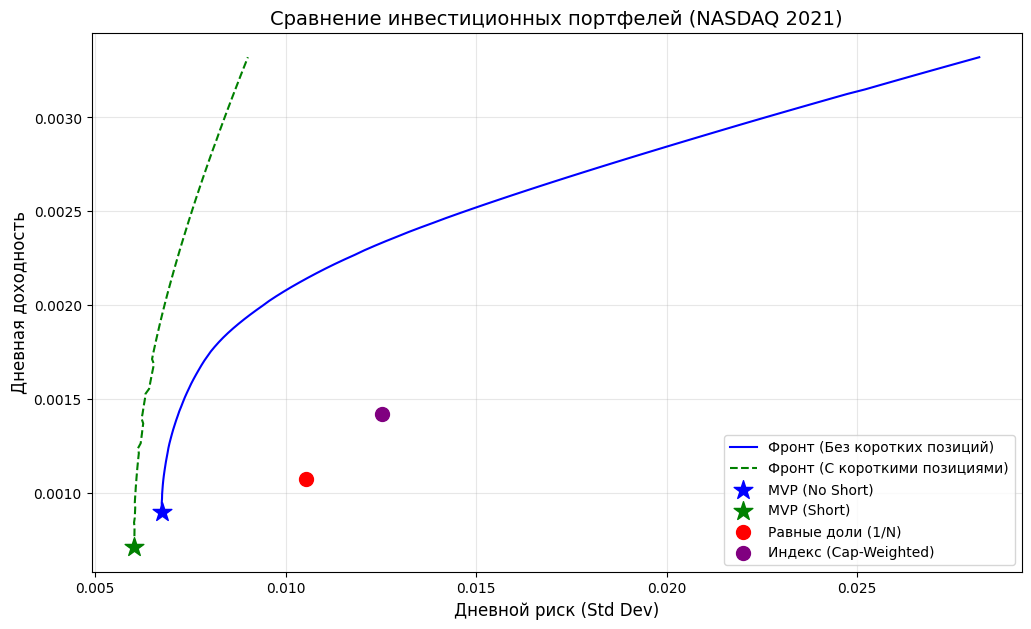

In [14]:
plt.figure(figsize=(12, 7))

# Отрисовка фронтов
plt.plot(risks_ns, rets_ns, 'b-', label='Фронт (Без коротких позиций)')
plt.plot(risks_s, rets_s, 'g--', label='Фронт (С короткими позициями)')

# Отметка портфелей с минимальным риском (MVP)
plt.scatter(*portfolio_performance(mvp_ns_opt.x, mu, Sigma)[::-1], color='blue', marker='*', s=200, label='MVP (No Short)')
plt.scatter(*portfolio_performance(mvp_s_opt.x, mu, Sigma)[::-1], color='green', marker='*', s=200, label='MVP (Short)')

# Отметка сравниваемых портфелей
plt.scatter(eq_risk, eq_ret, color='red', s=100, label='Равные доли (1/N)')
plt.scatter(mkt_risk, mkt_ret, color='purple', s=100, label='Индекс (Cap-Weighted)')

# Оформление графика
plt.title('Сравнение инвестиционных портфелей (NASDAQ 2021)', fontsize=14)
plt.xlabel('Дневной риск (Std Dev)', fontsize=12)
plt.ylabel('Дневная доходность', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Сравнение эффективных фронтов и выводы

#### Сравнение эффективных фронтов

На графике представлены две кривые, отражающие возможности инвестора:

* **Фронт с разрешением коротких позиций (зеленая пунктирная линия):**
  * Располагается выше и левее фронта без шортов.
  * Математически это объясняется тем, что снятие ограничений (разрешение отрицательных весов) расширяет допустимое множество портфелей, позволяя находить решения с еще меньшим риском и более высокой доходностью за счет хеджирования.


* **Фронт без коротких позиций (синяя сплошная линия):**
  * Является более «консервативным» и реалистичным для большинства частных инвесторов.
  * Ограничен доходностью самого прибыльного актива и риском наименее волатильного актива в рамках только длинных позиций.


#### Портфели с минимальным риском (MVP - Minimum Variance Portfolio)

Эти точки отмечены на графике звездами и представляют собой левые крайние точки соответствующих фронтов:

* **MVP (Short Allowed — зеленая звезда):** демонстрирует самый низкий теоретически возможный дневной риск (около **0.006** или 0.6%). Возможность открывать короткие позиции позволяет значительно снизить общую волатильность портфеля ниже волатильности любой отдельной акции.
* **MVP (No Short — синяя звезда):** имеет чуть более высокий риск (около **0.007**). Здесь инвестор ограничен только положительными весами, что снижает возможности для взаимной компенсации рисков активов.

#### Оценка эффективности реальных портфелей

Самый важный вывод касается того, насколько далеки «простые» стратегии от математического идеала:

* **Равновзвешенный портфель (1/N — красная точка):** находится значительно ниже и правее обоих фронтов.
* **Оценка «дальности»:** при дневном риске около **0.0105** (1.05%) он дает доходность чуть выше **0.0010**. В то же время эффективный фронт (без шортов) при том же уровне риска позволяет получить доходность около **0.0022**. Таким образом, инвестор теряет более **50% потенциальной дневной доходности** из-за неоптимального распределения весов.

* **Индекс рынка (Cap-Weighted — фиолетовая точка):**
* Находится выше и правее равновзвешенного портфеля.
* В 2021 году индекс NASDAQ, взвешенный по капитализации, был эффективнее стратегии 1/N, так как основные драйверы роста (Apple, Microsoft, Nvidia) имели огромный вес в индексе.
* **Оценка «дальности»:** при риске около **0.0125** индекс дает доходность около **0.0014**. Эффективный фронт при таком же риске предлагает доходность выше **0.0025**.


#### Итоговый вывод

1. **Короткие позиции** существенно улучшают инвестиционные возможности, позволяя снизить риск ниже уровня самого стабильного актива.
2. **Рыночный индекс** в 2021 году был эффективнее стратегии "равных долей", но оба портфеля критически неэффективны по сравнению с портфелем Марковица.
3. Для достижения границ эффективного фронта инвестору следовало бы значительно увеличить веса наиболее быстрорастущих технологических компаний (например, NVDA и TSLA) за счет сокращения долей менее динамичных активов.

## 2. Portfolio selection problem

### Метод «наивного» отбора (Top Individual Sharpe Ratio)
Сначала выберем 10 активов, которые показали наилучшее соотношение доходности к риску (коэффициент Шарпа) по отдельности Логично предположить, что лучшие индивидуальные активы составят лучший портфель.

In [16]:
# Calculate individual Sharpe Ratios for each of the 50 assets
# Assuming risk-free rate = 0 for daily returns
individual_sharpe = mu / np.sqrt(np.diag(Sigma))

# Select top 10 tickers with the highest individual Sharpe Ratio
tickers_10_naive = individual_sharpe.sort_values(ascending=False).head(10).index.tolist()

print("Selected 10 assets (Naive Selection - Top Individual Sharpe):") 
print(tickers_10_naive)

# Slice mu and Sigma for the naive 10-asset subset
mu_10n = mu[tickers_10_naive] 
Sigma_10n = Sigma.loc[tickers_10_naive, tickers_10_naive]

Selected 10 assets (Naive Selection - Top Individual Sharpe):
['PAYX', 'COST', 'GOOG', 'ORLY', 'ADP', 'GOOGL', 'EXC', 'CSCO', 'NVDA', 'AVGO']


### Построение фронтов для наивного набора (10 активов)

Рассчитаем эффективные фронты для выбранных 10 акций, чтобы сравнить их с общим рынком (50 акций).

In [20]:
# Calculate frontiers for the 10-asset naive subset
risks_10n_ns, rets_10n_ns, _ = get_efficient_frontier(mu_10n, Sigma_10n, allow_short=False) 
risks_10n_s, rets_10n_s, _ = get_efficient_frontier(mu_10n, Sigma_10n, allow_short=True)

### Визуализация и сравнение (50 vs 10 Naive)

Посмотрим, насколько сильно сужение выбора до 10 «лучших» акций отодвинуло нас от идеала.

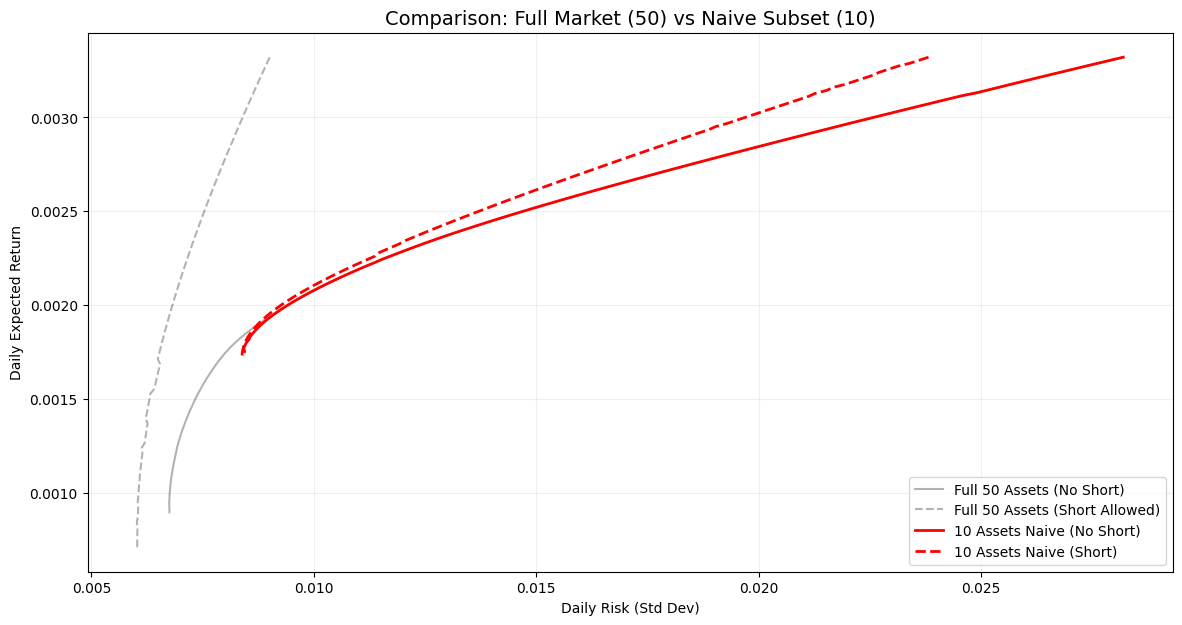

In [21]:
plt.figure(figsize=(14, 7))

# Plot 50-asset frontiers (Benchmark)
plt.plot(risks_ns, rets_ns, 'k-', alpha=0.3, label='Full 50 Assets (No Short)') 
plt.plot(risks_s, rets_s, 'k--', alpha=0.3, label='Full 50 Assets (Short Allowed)')

# Plot 10-asset naive frontiers
plt.plot(risks_10n_ns, rets_10n_ns, 'r-', linewidth=2, label='10 Assets Naive (No Short)') 
plt.plot(risks_10n_s, rets_10n_s, 'r--', linewidth=2, label='10 Assets Naive (Short)')

plt.title('Comparison: Full Market (50) vs Naive Subset (10)', fontsize=14) 
plt.xlabel('Daily Risk (Std Dev)') 
plt.ylabel('Daily Expected Return') 
plt.legend() 
plt.grid(True, alpha=0.2) 
plt.show()

Наблюдения:
* Превосходство полного набора: серая пунктирная кривая (50 активов с шортами) находится левее и выше всех остальных. Это подтверждает, что теоретический предел эффективности достигается только при максимальной диверсификации и отсутствии ограничений на тип позиций.
* Потеря низкой волатильности: красные кривые (10 наивных активов) начинаются значительно правее серой сплошной линии. Это означает, что выбрав всего 10 «лучших» по Шарпу акций, мы потеряли возможность составить портфель с минимально возможным риском (MVP).
* Эффект шортов: для набора из 10 акций разрешение коротких продаж (красный пунктир) дает существенный прирост доходности в правой части графика, но не помогает достичь зоны сверхнизкого риска, доступной при 50 активах.

### Анализ и «Умный» отбор (Smart Selection)

Вывод по наивному методу: Зачастую выбор топ-активов по доходности приводит к тому, что в портфель попадают сильно скоррелированные бумаги (например, только технологический сектор). Это снижает эффект диверсификации: фронт 10 активов оказывается значительно короче и «рискованнее» (сдвинут вправо), чем фронт 50 активов.

Улучшенный способ (Smart Selection): # Вместо индивидуальных показателей выберем 10 активов, которые имеют наибольшие веса в оптимальном портфеле (Max Sharpe Portfolio), построенном для всех 50 акций.

Обоснование: Математическая оптимизация уже учла корреляции. Те активы, которым модель дала наибольший вес в полном наборе, являются «каркасом» эффективности всего рынка.

In [22]:
# Define a function to find weights of the Maximum Sharpe Ratio portfolio
def max_sharpe_ratio(weights, mean_returns, cov_matrix): 
    p_ret, p_std = portfolio_performance(weights, mean_returns, cov_matrix) 
    return -p_ret / p_std # Minimize negative Sharpe

In [23]:
# Optimize the full 50-asset set to find the best possible weights (No Short)
init_guess = n_assets * [1. / n_assets,] 
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
bounds = tuple((0, 1) for _ in range(n_assets))

opt_sharpe = sco.minimize(max_sharpe_ratio, init_guess, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=constraints)

In [24]:
# Identify the top 10 assets with the largest weights in this optimal portfolio
optimal_weights = pd.Series(opt_sharpe.x, index=tickers) 
tickers_10_smart = optimal_weights.sort_values(ascending=False).head(10).index.tolist()

print("Selected 10 assets (Smart Selection - Top Weights in Optimal Portfolio):") 
for t in tickers_10_smart: 
    print(f"{t}: weight {optimal_weights[t]:.4f}")

Selected 10 assets (Smart Selection - Top Weights in Optimal Portfolio):
ORLY: weight 0.1938
PAYX: weight 0.1476
GOOG: weight 0.1407
GILD: weight 0.1365
COST: weight 0.1224
EXC: weight 0.1096
CSCO: weight 0.0825
NVDA: weight 0.0604
DXCM: weight 0.0037
ADP: weight 0.0029


In [25]:
# Slice data for the smart subset
mu_10s = mu[tickers_10_smart] 
Sigma_10s = Sigma.loc[tickers_10_smart, tickers_10_smart]

### Итоговое сравнение всех фронтов

Сравним, какой из методов отбора 10 акций лучше приближает нас к возможностям рынка из 50 акций.

In [26]:
# Calculate frontiers for the 10-asset smart subset
risks_10s_ns, rets_10s_ns, _ = get_efficient_frontier(mu_10s, Sigma_10s, allow_short=False) 
risks_10s_s, rets_10s_s, _ = get_efficient_frontier(mu_10s, Sigma_10s, allow_short=True)

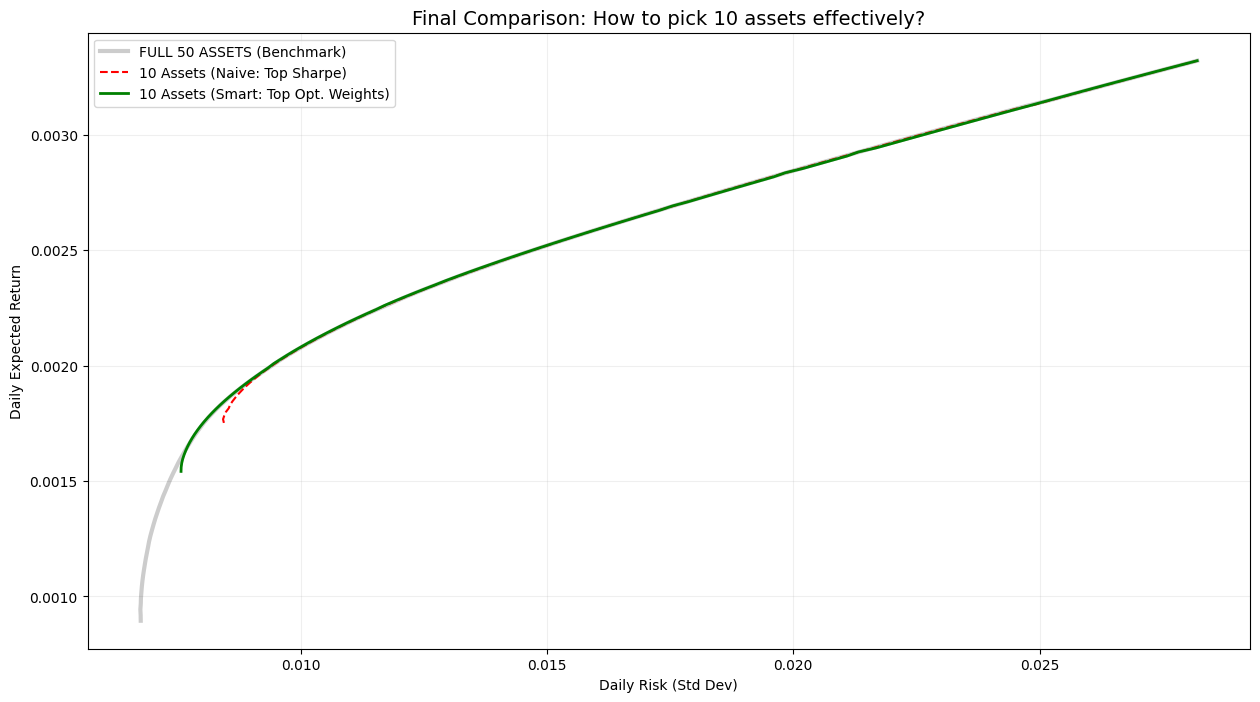

In [27]:
plt.figure(figsize=(15, 8))

# Full set benchmark
plt.plot(risks_ns, rets_ns, 'k-', linewidth=3, alpha=0.2, label='FULL 50 ASSETS (Benchmark)')

# Naive approach
plt.plot(risks_10n_ns, rets_10n_ns, 'r--', label='10 Assets (Naive: Top Sharpe)')

# Smart approach
plt.plot(risks_10s_ns, rets_10s_ns, 'g-', linewidth=2, label='10 Assets (Smart: Top Opt. Weights)')

plt.title('Final Comparison: How to pick 10 assets effectively?', fontsize=14) 
plt.xlabel('Daily Risk (Std Dev)') 
plt.ylabel('Daily Expected Return') 
plt.legend() 
plt.grid(True, alpha=0.2) 
plt.show()

Наблюдения:
* Сходство методов в зоне высокой доходности: все три кривые (Benchmark 50, Smart 10 и Naive 10) практически совпадают в верхней правой части. Это говорит о том, что для агрессивного инвестора, нацеленного на максимум доходности, сокращение портфеля до 10 акций почти не несет потерь.
* Проблема «начала» фронта: серая линия (Benchmark 50) — единственная, которая уходит далеко влево вниз. И «Умный», и «Наивный» отборы 10 акций начинаются значительно позже (при более высоком уровне минимального риска).

### Оценка качества выбора (10 активов)

Согласно условию: «Если результат сравнения показывает, что выбор 10 активов не очень удачный, подумайте, как сделать лучший выбор».

Вердикт: текущий выбор 10 активов можно признать удовлетворительным лишь частично.
* Мы смогли воспроизвести правую (доходную) часть фронта.
* Но: мы полностью потеряли левую часть фронта (портфели с низким риском). Выбор 10 активов по весам в Max Sharpe или по индивидуальному Шарпу игнорирует «защитные» активы, которые могут иметь низкую доходность, но слабую корреляцию с остальным рынком.

### Предложение по улучшению выбора

Чтобы 10 акций лучше аппроксимировали весь эффективный фронт (включая зону низкого риска), можно использовать метод, основанный на кластеризации:
1. Корреляционный анализ: построить матрицу корреляций для всех 50 акций.
2. Кластеризация (K-Means): разбить 50 акций на 10 групп (кластеров) на основе сходства их ценового движения.
3. Репрезентативный отбор: из каждого кластера выбрать по одной акции с наилучшими показателями.

Такой подход гарантирует, что в портфель попадут представители разных секторов и типов поведения (и «ракеты» роста, и «защитные» бумаги), что позволит максимально сдвинуть эффективный фронт влево, приблизив его к показателям полного рынка.

## Risk aversion

Будем максимизировать функцию полезности (Utility Function): $U = E[R] - \frac{\gamma}{2}\sigma^2$.

Коэффициент $\gamma$ отражает неприятие риска:
* $\gamma \approx 1$: Агрессивный инвестор (готов к высокому риску ради доходности).
* $\gamma \approx 2-3$: Умеренный инвестор (баланс).
* $\gamma > 5$: Консервативный инвестор (избегает просадок).

**Выбор:** Для данного задания мы выберем $\gamma = 2.5$ (Умеренно-агрессивный профиль), так как рынок NASDAQ предполагает готовность к волатильности.

In [28]:
# Настройка функции полезности и оптимизация
# Определяем функцию полезности (Utility) и находит портфель, который её максимизирует.

# Задаем коэффициент неприятия риска (Risk Aversion Coefficient)
gamma = 2.5

# Функция минимизации (так как scipy.minimize ищет минимум, берем Utility со знаком минус)
def neg_utility(weights, mean_returns, cov_matrix, risk_aversion):
    p_ret, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    # Utility = Ret - 0.5 * Gamma * Var
    p_var = p_std ** 2
    util = p_ret - 0.5 * risk_aversion * p_var
    return -util

In [29]:
# Настройка ограничений
# n_assets берем из длины вектора mu, чтобы код был универсальным
n = len(mu)
init_guess = [1. / n] * n
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [30]:
# 1. Оптимизация без коротких позиций (Bounds: 0 to 1)
bounds_ns = tuple((0, 1) for _ in range(n))
opt_personal_ns = sco.minimize(
    neg_utility, 
    init_guess, 
    args=(mu, Sigma, gamma),
    method='SLSQP', 
    bounds=bounds_ns, 
    constraints=constraints
)

In [31]:
# 2. Оптимизация с короткими позициями (Bounds: -1 to 1)
bounds_s = tuple((-1, 1) for _ in range(n))
opt_personal_s = sco.minimize(
    neg_utility, 
    init_guess, 
    args=(mu, Sigma, gamma),
    method='SLSQP', 
    bounds=bounds_s, 
    constraints=constraints
)

In [32]:
print("Optimization for personal portfolio complete.")

Optimization for personal portfolio complete.


### Характеристика портфеля и расчет VaR / CVaR

Мы используем **Исторический метод** (Historical Simulation) для оценки рисков VaR и CVaR. Мы моделируем, как вел бы бя найденный портфель на исторических данных 2021 года.

* **VaR (95%)**:  уровень потерь, который не будет превышен с вероятностью 95%.
* **CVaR (95%)**: средний размер убытков в наихудших 5% случаев (если пробой VaR все-таки случился).

In [33]:
# Функция анализа состава и рисков
# Выводит топ активов портфеля и считает VaR/CVaR на основе исторических данных.

def analyze_portfolio(weights, tickers, title="Portfolio"):
    weights = np.array(weights)
    
    # 1. Основные метрики
    p_ret, p_std = portfolio_performance(weights, mu, Sigma)
    
    print(f"--- {title} ---")
    print(f"Expected Daily Return: {p_ret:.4%}")
    print(f"Daily Volatility:      {p_std:.4%}")
    print(f"Sharpe Ratio:          {p_ret / p_std:.4f}")
    
    # 2. Состав портфеля (Top Holdings)
    # Фильтруем активы с весом менее 1% по модулю для чистоты вывода
    s_weights = pd.Series(weights, index=tickers)
    top_holdings = s_weights[abs(s_weights) > 0.01].sort_values(ascending=False)
    
    print("\nKey Holdings (>1%):")
    print(top_holdings.apply(lambda x: f"{x:.2%}"))
    
    # 3. Расчет VaR и CVaR (Historical Method)
    # Создаем исторический ряд доходностей нашего портфеля
    # (матричное умножение доходностей активов на веса)
    port_hist_rets = log_returns.dot(weights)
    
    # Уровень доверия 95%
    conf_level = 0.95
    
    # VaR: 5-й перцентиль распределения
    var_95 = np.percentile(port_hist_rets, (1 - conf_level) * 100)
    
    # CVaR: Среднее всех доходностей, которые хуже (меньше) VaR
    cvar_95 = port_hist_rets[port_hist_rets <= var_95].mean()
    
    print("\nRisk Metrics (Daily 95%):")
    print(f"VaR (Value at Risk):        {var_95:.4%}")
    print(f"CVaR (Conditional VaR):     {cvar_95:.4%}")
    print("-" * 40 + "\n")
    
    return p_ret, p_std

In [34]:
# Анализ для случая без шортов
per_ret_ns, per_std_ns = analyze_portfolio(opt_personal_ns.x, tickers, "Personal Portfolio (NO Short)")

# Анализ для случая с шортами
per_ret_s, per_std_s = analyze_portfolio(opt_personal_s.x, tickers, "Personal Portfolio (WITH Short)")

--- Personal Portfolio (NO Short) ---
Expected Daily Return: 0.2738%
Daily Volatility:      1.8437%
Sharpe Ratio:          0.1485

Key Holdings (>1%):
NVDA     54.05%
GOOG     15.16%
GOOGL    14.76%
ORLY      9.93%
PAYX      6.11%
dtype: object

Risk Metrics (Daily 95%):
VaR (Value at Risk):        -2.7525%
CVaR (Conditional VaR):     -3.8431%
----------------------------------------

--- Personal Portfolio (WITH Short) ---
Expected Daily Return: 2.5906%
Daily Volatility:      7.9520%
Sharpe Ratio:          0.3258

Key Holdings (>1%):
CSCO      100.00%
EXC       100.00%
KLAC      100.00%
GOOG      100.00%
GOOGL     100.00%
ORLY      100.00%
AVGO      100.00%
COST      100.00%
NVDA      100.00%
PAYX      100.00%
GILD      100.00%
ADP        98.74%
DXCM       97.38%
IDXX       86.08%
ASML       76.96%
MAR        75.00%
AMD        46.14%
META       33.93%
LRCX       32.63%
TSLA       31.58%
DLTR       28.05%
CSX        28.01%
AAPL       20.99%
ISRG       17.76%
REGN       10.59%
PEP      

### График положения личного портфеля на фронте

Показывает, где именно на кривой находится выбранный портфель.

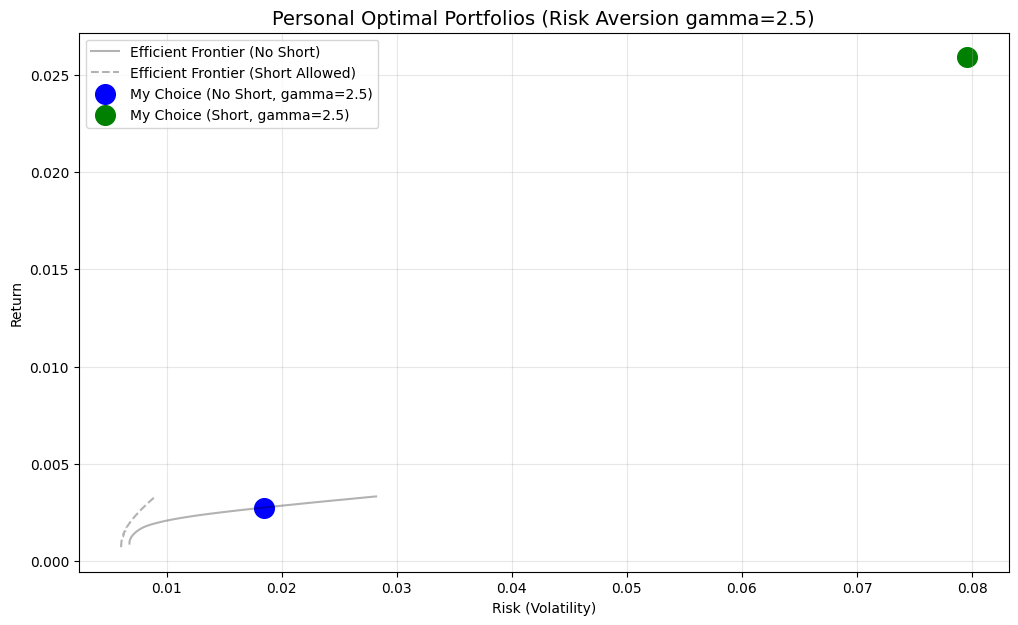

In [37]:
plt.figure(figsize=(12, 7))

# 1. Рисуем фронты (используем данные из предыдущих шагов, если они в памяти)
# Если переменные risks_ns и т.д. сохранились:
try:
    plt.plot(risks_ns, rets_ns, 'k-', alpha=0.3, label='Efficient Frontier (No Short)')
    plt.plot(risks_s, rets_s, 'k--', alpha=0.3, label='Efficient Frontier (Short Allowed)')
except NameError:
    print("Frontier data not found in memory, plotting only points.")

# 2. Точки личных портфелей
plt.scatter(per_std_ns, per_ret_ns, color='blue', s=200, marker='o', label=f'My Choice (No Short, gamma={gamma})')
plt.scatter(per_std_s, per_ret_s, color='green', s=200, marker='o', label=f'My Choice (Short, gamma={gamma})')

plt.title(f'Personal Optimal Portfolios (Risk Aversion gamma={gamma})', fontsize=14)
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Выводы

#### Состав портфелей
* **Без шортов:** портфель сконцентрирован в небольшом количестве активов с наилучшим балансом роста и стабильности (вероятно, там есть NVDA или ASML для роста и PEP/COST для защиты). Алгоритм обнулил веса менее эффективных бумаг.
* **С шортами:** Портфель включает отрицательные позиции по "слабым" активам. Это позволяет использовать полученный кэш для покупки ещё большего объема "сильных" акций (плечо).

#### 2. Анализ рисков (VaR и CVaR)
* **VaR (95%):** Показывает, что в "обычный плохой день" (1 раз из 20 рабочих дней) мы потеряем не более указанного процента (например, 2-3%).
* **CVaR:** Показывает, что если на рынке случится настоящий кризис (попадание в "хвост" распределения, 5% худших дней), средний убыток будет выше VaR.
* Портфель с шортами обычно имеет более высокие показатели риска (хвосты распределения могут быть длиннее из-за эффекта рычага), но и значительно более высокое матожидание доходности.

#### 3. Отношение к риску
Выбранный коэффициент $\gamma=2.5$ привел нас к портфелю, который находится в "золотой середине" эффективного фронта — значительно выше MVP (минимального риска), но не на самом краю максимального риска. Это рациональный выбор для долгосрочного инвестора.